# Part 1, Features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import time
import gc
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv.gz', compression='gzip')
test  = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

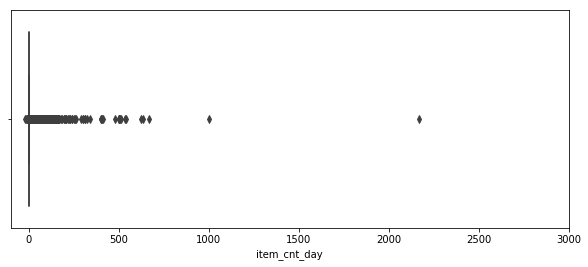

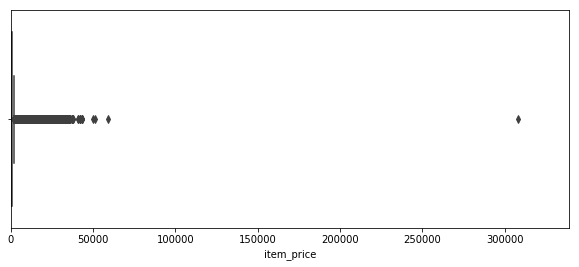

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with the price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

TF-IDF features from item_name.

In [8]:
tfidf = pd.DataFrame(TfidfVectorizer(max_features=12).fit_transform(items['item_name']).toarray(), dtype='float16')
tfidf.columns = ['tfidf_'+str(id+1) for id in range(12)]
tfidf.index.names = ['item_id']
tfidf.reset_index(inplace=True)

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [9]:
# matrix = pickle.load(open('matrix.pickle', 'rb'))

len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

In [10]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

12.917996406555176

Aggregate train set by shop/item pairs to calculate targets sum and count.Clip target value as (0,20)

<b>NB</b> I use floats instead of ints for item_cnt_month and orders to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.

In [11]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [12]:
ts = time.time()
train_agg = train.groupby(['date_block_num','shop_id','item_id']).agg({
    'item_cnt_day': ['sum', 'count'],
    'revenue': ['sum']
})
train_agg.columns = ['item_cnt_month', 'orders', 'revenue']
train_agg.reset_index(inplace=True)

matrix = pd.merge(matrix, train_agg, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix['orders'] = matrix['orders'].fillna(0).astype(np.float16)
matrix['revenue'] = matrix['revenue'].fillna(0).astype(np.float32)
time.time() - ts

8.06999683380127

## Test set

In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [14]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols) # there is no sort=False in python 3.5, columns are mixed
time.time() - ts

0.22699999809265137

In [15]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 6 columns):
date_block_num    int8
item_cnt_month    float16
item_id           int16
orders            float16
revenue           float32
shop_id           int8
dtypes: float16(2), float32(1), int16(1), int8(2)
memory usage: 127.3 MB


## Shops/Items/Cats features

In [16]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix.fillna(0, inplace=True)
time.time() - ts

8.199002742767334

## Traget lags

In [17]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [18]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix = lag_feature(matrix, [1,2,3], 'orders')
matrix = lag_feature(matrix, [1,2,3], 'revenue')
time.time() - ts

113.8529760837555

## Mean encoded features

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['mean'],
    'revenue': ['mean'],
})
group.columns = [ 'date_avg_item_cnt', 'date_avg_orders', 'date_avg_revenue' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix['date_avg_orders'] = matrix['date_avg_orders'].astype(np.float16)
matrix['date_avg_revenue'] = matrix['date_avg_revenue'].astype(np.float32)

matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_avg_orders')
matrix = lag_feature(matrix, [1], 'date_avg_revenue')

matrix.drop(['date_avg_item_cnt','date_avg_orders','date_avg_revenue'], axis=1, inplace=True)

time.time() - ts

52.07103180885315

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_month': ['mean' ],
    'orders': ['sum']
})
group.columns = [ 'date_item_avg_item_cnt', 'date_item_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix['date_item_sum_orders'] = matrix['date_item_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_sum_orders')

matrix.drop(['date_item_avg_item_cnt','date_item_sum_orders'], axis=1, inplace=True)

time.time() - ts

134.33999752998352

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_month': ['mean' ],
    'orders': ['sum']
})
group.columns = [ 'date_shop_avg_item_cnt', 'date_shop_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix['date_shop_sum_orders'] = matrix['date_shop_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_sum_orders')

matrix.drop(['date_shop_avg_item_cnt','date_shop_sum_orders'], axis=1, inplace=True)

time.time() - ts

148.8289954662323

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum']
})
group.columns = [ 'date_cat_avg_item_cnt', 'date_cat_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix['date_cat_sum_orders'] = matrix['date_cat_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3], 'date_cat_avg_item_cnt')
matrix = lag_feature(matrix, [1,2,3], 'date_cat_sum_orders')

matrix.drop(['date_cat_avg_item_cnt','date_cat_sum_orders'], axis=1, inplace=True)
time.time() - ts

110.44519901275635

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum']
})
group.columns = [ 'date_shop_cat_avg_item_cnt', 'date_shop_cat_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix['date_shop_cat_sum_orders'] = matrix['date_shop_cat_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_shop_cat_sum_orders')

matrix.drop(['date_shop_cat_avg_item_cnt','date_shop_cat_sum_orders'], axis=1, inplace=True)
time.time() - ts

67.69156551361084

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum']
})
group.columns = [ 'date_city_avg_item_cnt', 'date_city_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix['date_city_sum_orders'] = matrix['date_city_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_city_sum_orders')

matrix.drop(['date_city_avg_item_cnt','date_city_sum_orders'], axis=1, inplace=True)
time.time() - ts

72.0315375328064

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum']
})
group.columns = [ 'date_item_city_avg_item_cnt', 'date_item_city_sum_orders' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix['date_item_city_sum_orders'] = matrix['date_item_city_sum_orders'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_item_city_sum_orders')

matrix.drop(['date_item_city_avg_item_cnt','date_item_city_sum_orders'], axis=1, inplace=True)
time.time() - ts

81.65566110610962

In [26]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 56 columns):
date_block_num                       int8
item_cnt_month                       float16
item_id                              int16
orders                               float16
revenue                              float32
shop_id                              int8
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
orders_lag_1                         float16
orders_lag_2                         float16
orders_lag_3                         float16
revenue_lag_1                        float32
revenue_lag_2                        float32
reven

## Price features

In [27]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
time.time() - ts

17.801997423171997

Price trends. TODO create one lag best_avg - month_avg / month_avg

In [28]:
ts = time.time()
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

360.0341498851776

Mean targets

In [29]:
ts = time.time()
group = train_agg.groupby(['shop_id', 'item_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['mean'],
    'revenue': ['mean'],
})
group.columns = [ 'shop_item_avg_item_cnt', 'shop_item_avg_orders', 'shop_item_avg_revenue' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id','item_id'], how='left')
matrix['shop_item_avg_item_cnt'] = matrix['shop_item_avg_item_cnt'].astype(np.float16)
matrix['shop_item_avg_orders'] = matrix['shop_item_avg_orders'].astype(np.float16)
matrix['shop_item_avg_revenue'] = matrix['shop_item_avg_revenue'].astype(np.float32)
time.time() - ts

21.37999939918518

In [30]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 61 columns):
date_block_num                       int8
item_cnt_month                       float16
item_id                              int16
orders                               float16
revenue                              float32
shop_id                              int8
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
orders_lag_1                         float16
orders_lag_2                         float16
orders_lag_3                         float16
revenue_lag_1                        float32
revenue_lag_2                        float32
reven

## Special features

Month (0 - Jan, 11 - Dec)

In [31]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [32]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since last sale for each shop/item pair and for item only. I use programing approach.

Create hash table with key equals to {shop_id,item_id} and value equals date_block_num. Iterate data from the top. Foreach row if {row.shop_id,item_id} is not present in the table, then add to the table and set its value to row.date_blocl_num. if hash table contains key, then calculate the difference beteween cached value and row.date_block_num.

In [33]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

900.3713910579681

In [34]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

526.6065859794617

Months since first sale for each shop/item pair and for item only.

In [35]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] \
    - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] \
    - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

4.07699990272522

TFIDF

In [36]:
# data = pd.merge(data, tfidf, on='item_id', how='left')

## Final preparations

Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [37]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
matrix.drop(['orders', 'revenue'], axis=1, inplace=True)
time.time() - ts

4.455997467041016

TODO Deal with nulls

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if df[col].isnull().any():
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            if ('orders' in col):
                df[col].fillna(0, inplace=True)
            if ('item_price' in col):
                df[col].fillna(df[col].median(), inplace=True)
    return df

data = fill_na(data)
time.time() - ts

In [38]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 65 columns):
date_block_num                       int8
item_cnt_month                       float16
item_id                              int16
shop_id                              int8
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
orders_lag_1                         float16
orders_lag_2                         float16
orders_lag_3                         float16
revenue_lag_1                        float32
revenue_lag_2                        float32
revenue_lag_3                        float32
date_avg_item_cnt_lag_1              float16


## File

In [39]:
matrix.to_pickle('matrix.pickle')

# Part 2, xgboost

In [40]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [41]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [42]:
del matrix
del cache
del train_agg
del group
del tfidf
del items
del shops
del train
del test
gc.collect();

In [43]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    colsample_bylevel=0.8, 
    subsample=0.8, 
    eta=0.3, 
    num_round=1000,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.13249	validation_1-rmse:1.08563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.06635	validation_1-rmse:1.01055
[2]	validation_0-rmse:1.01002	validation_1-rmse:0.950358
[3]	validation_0-rmse:0.960502	validation_1-rmse:0.898299
[4]	validation_0-rmse:0.918037	validation_1-rmse:0.853343
[5]	validation_0-rmse:0.881789	validation_1-rmse:0.816895
[6]	validation_0-rmse:0.850698	validation_1-rmse:0.783608
[7]	validation_0-rmse:0.824087	validation_1-rmse:0.756689
[8]	validation_0-rmse:0.801138	validation_1-rmse:0.735314
[9]	validation_0-rmse:0.781874	validation_1-rmse:0.715383
[10]	validation_0-rmse:0.765976	validation_1-rmse:0.701061
[11]	validation_0-rmse:0.752117	validation_1-rmse:0.691774
[12]	validation_0-rmse:0.739665	validation_1-rmse:0.679596
[13]	validation_0-rmse:0.728874	validation_1-rmse:0.67002
[14]	validation_0-rmse:0.719641

3428.6979093551636

In [44]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

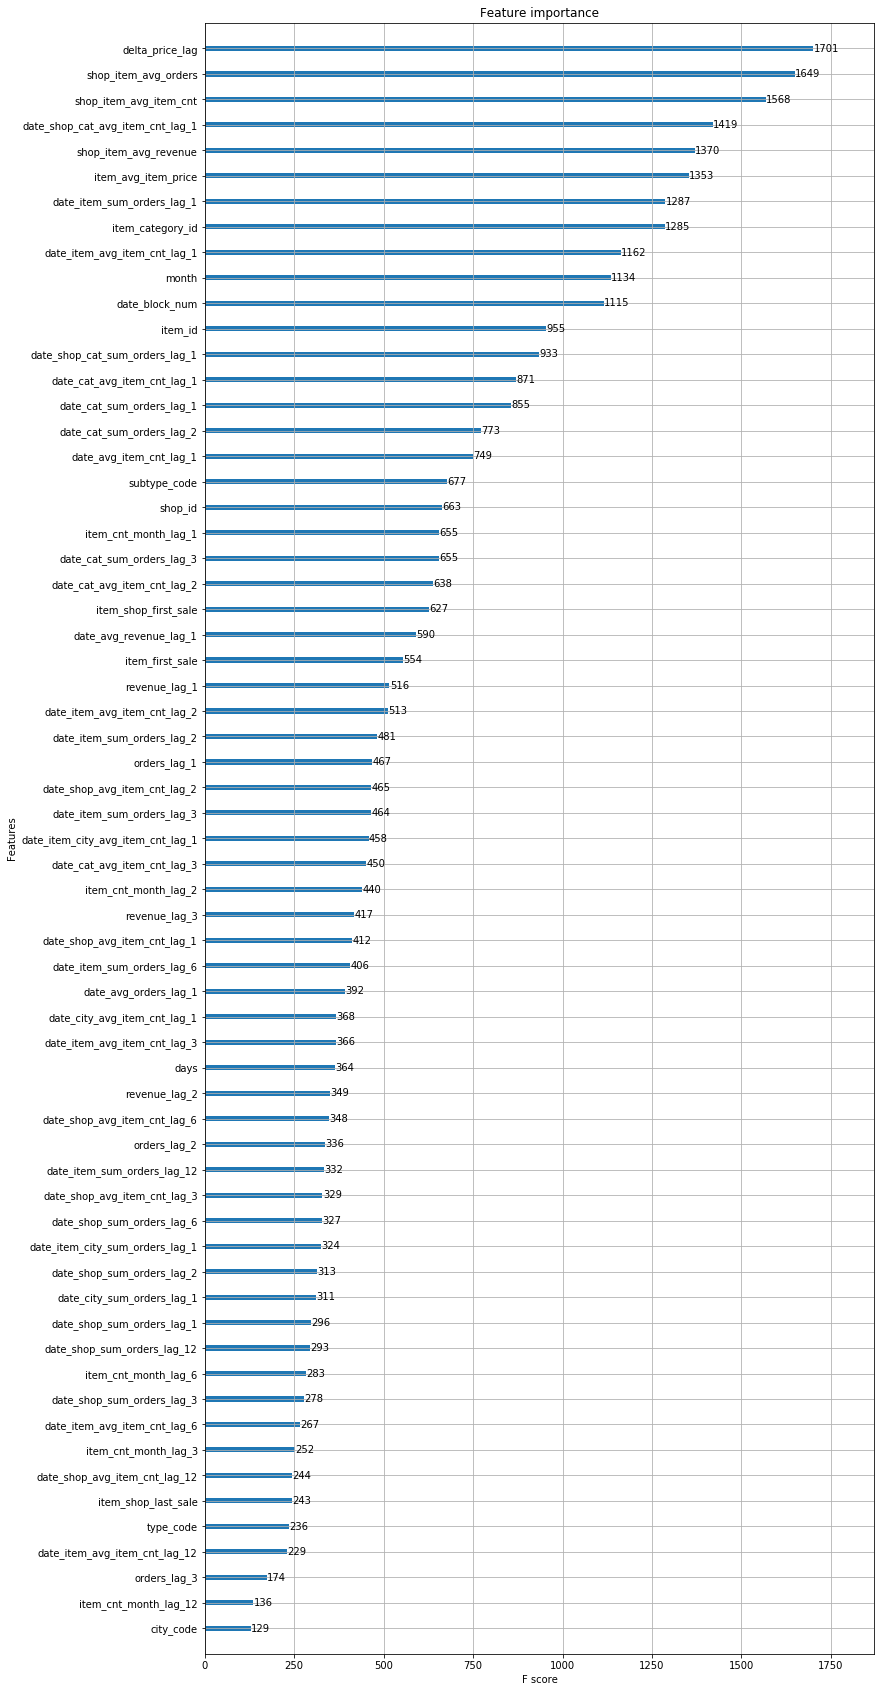

In [47]:
plot_features(model, (12,30))

In [46]:
test  = pd.read_csv('test.csv.gz', compression='gzip')
submission = pd.DataFrame({
    'ID': test['ID'], 
    'item_cnt_month': Y_test
})
submission.to_csv('xgb_submission.csv', index=False)